Node coordinates (x, y):
[[0.         0.        ]
 [0.16666667 0.        ]
 [0.33333333 0.        ]
 [0.5        0.        ]
 [0.66666667 0.        ]
 [0.83333333 0.        ]
 [1.         0.        ]
 [1.16666667 0.        ]
 [1.33333333 0.        ]
 [1.5        0.        ]
 [1.66666667 0.        ]
 [1.83333333 0.        ]
 [2.         0.        ]
 [2.16666667 0.        ]
 [2.33333333 0.        ]
 [2.5        0.        ]
 [2.66666667 0.        ]
 [2.83333333 0.        ]
 [3.         0.        ]
 [3.16666667 0.        ]
 [3.33333333 0.        ]
 [3.5        0.        ]
 [3.66666667 0.        ]
 [3.83333333 0.        ]
 [4.         0.        ]
 [0.         0.14285714]
 [0.16666667 0.14285714]
 [0.33333333 0.14285714]
 [0.5        0.14285714]
 [0.66666667 0.14285714]
 [0.83333333 0.14285714]
 [1.         0.14285714]
 [1.16666667 0.14285714]
 [1.33333333 0.14285714]
 [1.5        0.14285714]
 [1.66666667 0.14285714]
 [1.83333333 0.14285714]
 [2.         0.14285714]
 [2.16666667 0.14285714]


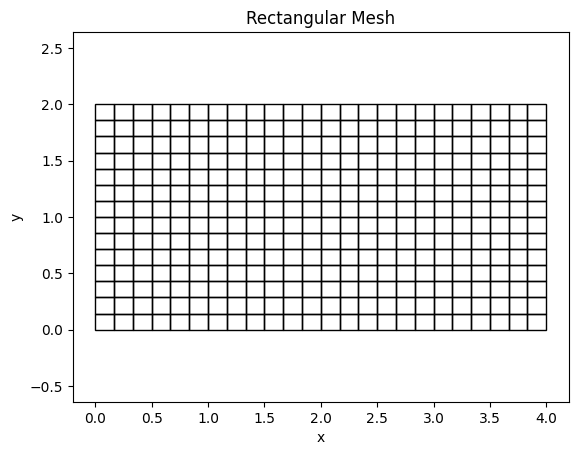

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from SSDpy.num.plates import plate12DOFs as plate

# Mesh definition
nX, nY = 25,  15  # Number of nodes
Lx, Ly = 4., 2.  # Floor dimensions [m]

dx = Lx / (nX - 1)
dy = Ly / (nY - 1)

x = np.linspace(0, Lx, nX)
y = np.linspace(0, Ly, nY)
X, Y = np.meshgrid(x, y)

# Nodes list
nodes = np.column_stack([X.flatten(), Y.flatten()])

# Element connectivity
elements = []
for i in range(nX - 1):
    for j in range(nY - 1):
        node1 = j * nX + i
        node2 = j * nX + (i + 1)
        node3 = (j + 1) * nX + i
        node4 = (j + 1) * nX + (i + 1)
        elements.append([node1, node2, node4, node3])

elements = np.array(elements)

# Display the nodes and elements
print("Node coordinates (x, y):")
print(nodes)

print("\nElement connectivity:")
print(elements)

# Plot the mesh
plt.figure()
for element in elements:
    coords = nodes[element]
    plt.fill(coords[:, 0], coords[:, 1], edgecolor='k', fill=False)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Rectangular Mesh')
plt.show()

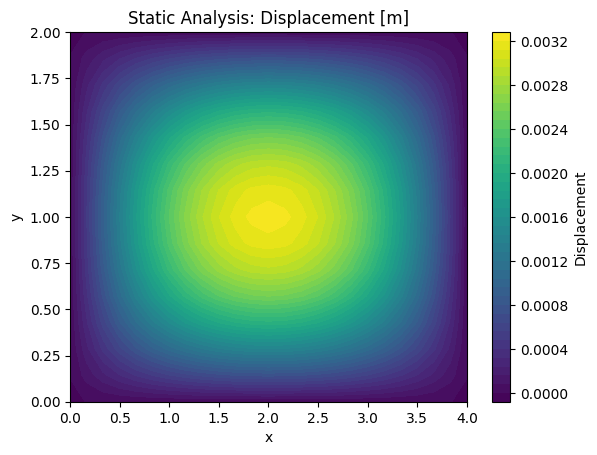

In [2]:
# Assemble stiffness matrix
E = 200.e9   # Young's modulus [N/m^2]
e = 0.020    # Thickness [m]
nu = 0.3     # Poisson's ratio
q = 2000.    # Uniform load [N/m^2]
rho = 7850.   # Mass density, used for mass matrix and vibration analysis only [kg/m^3]

D = E * e**3 / (12 * (1 - nu**2))  # Flexural rigidity
mu = rho * e  # Mass per unit area

ndof = 3 * len(nodes)

Ktot = np.zeros((ndof, ndof))
Mtot = np.zeros((ndof, ndof))
ptot = np.zeros(ndof)
elements_idofs = []

for element in elements:
    idofs = []
    for node in element:
        idofs.extend([3 * node + i for i in range(3)])
    elements_idofs.append(idofs)
    dxdy = np.ptp(nodes[element], axis=0)
    a, b = dxdy[0] / 2, dxdy[1] / 2

    Ke = plate.stiffness_12dof(a, b, D, nu)
    Me = plate.mass_12dof(a, b, mu)
    pe = plate.load_12dof(a, b, q)

    Ktot[np.ix_(idofs, idofs)] += Ke
    Mtot[np.ix_(idofs, idofs)] += Me
    ptot[idofs] += pe    

# Apply boundary conditions - use a penalty method
dKtot = np.diag(Ktot)
K_transl = 1000 * np.max(dKtot[::3])
K_rot = 1000 * np.max(dKtot[1::3])

bottom_edge = np.where(nodes[:, 1] == 0)[0]
top_edge = np.where(nodes[:, 1] == Ly)[0]
left_edge = np.where(nodes[:, 0] == 0)[0]
right_edge = np.where(nodes[:, 0] == Lx)[0]

supported_nodes = np.unique(np.concatenate([bottom_edge, top_edge, left_edge, right_edge]))
fixed_dofs_transl = 3 * supported_nodes

for dof in fixed_dofs_transl:
    Ktot[dof, dof] += K_transl

# run static analysis
U = np.linalg.solve(Ktot, ptot)
u = U[::3].reshape((nY, nX))

plt.figure()
plt.contourf(x, y, u, levels=50, cmap='viridis')
plt.colorbar(label='Displacement')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Static Analysis: Displacement [m]')
plt.show()

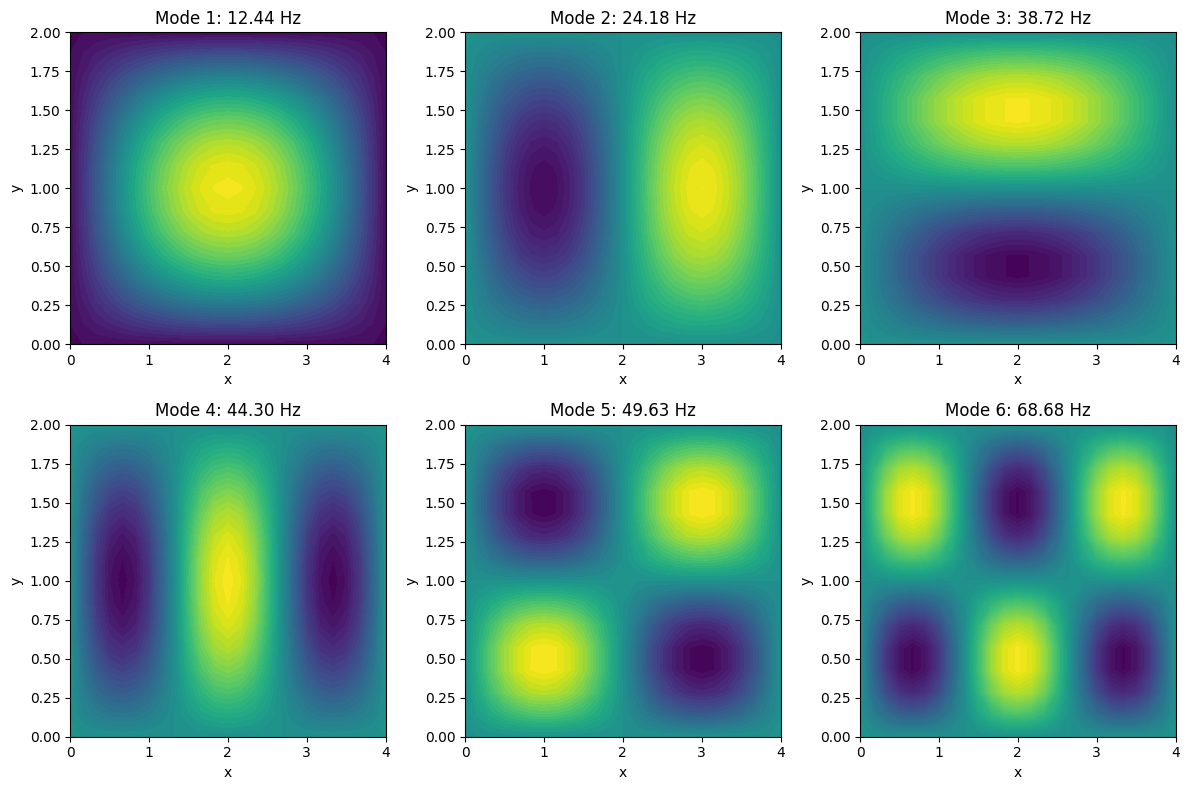

In [14]:
# Modal analysis
eigvals, eigvecs = np.linalg.eig(np.linalg.inv(Mtot) @ Ktot)
natural_freqs = np.sqrt(eigvals) / (2 * np.pi)
# Sort from lowest to highest frequency
sorted_indices = np.argsort(natural_freqs)
natural_freqs = natural_freqs[sorted_indices]
eigvecs = eigvecs[:, sorted_indices]

# Display the first few natural frequencies
rows = 2
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))

for i in range(rows * cols):
    U_modal = eigvecs[:, i]
    U_modal = U_modal[::3].reshape((nY, nX))
    ax = axes[i // cols, i % cols]
    c = ax.contourf(x, y, U_modal, levels=50, cmap='viridis')
    ax.set_title(f'Mode {i + 1}: {natural_freqs[i]:.2f} Hz')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
plt.tight_layout()
